In [28]:
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
shuffle = False

In [30]:
from Corrfunc.utils import check_runtime_env

In [31]:
from Corrfunc._countpairs import countpairs as DD_extn

In [32]:
import Corrfunc._countpairs

In [33]:
import os.path
import numpy as np
import pandas as pd
import h5py as h5
# parser.add_argument('boxsize') #L
# parser.add_argument('bin_file')
# parser.add_argument('mock_file1')
# parser.add_argument('mock_file2')
# parser.add_argument('output_file')
# parser.add_argument('--siglnMc') #scatter between intrinsic 
# parser.add_argument('--nc') #cluster number density
# parser.add_argument('--zphot') #photo-z
# parser.add_argument('--Qsel') #assembly bias term 
# parser.add_argument('--delg') #R_delta
# parser.add_argument('--downsample_flag')

In [34]:
check_runtime_env()

/global/homes/z/zchusre/.conda/envs/desdesi/lib/python3.8/site-packages/Corrfunc/utils.py:1071: UserWarning: Warning: Cray hugepages has a bug that may crash Corrfunc. You might be able to fix such a crash with `module unload craype-hugepages2M` (see https://github.com/manodeep/Corrfunc/issues/245 for details)
  warnings.warn('Warning: Cray hugepages has a bug that may crash '


<ipython-input-35-761f299786ce>:2: RuntimeWarning: divide by zero encountered in log
  return 0.5*(1+scipy.special.erf(np.log(M)/0.6))


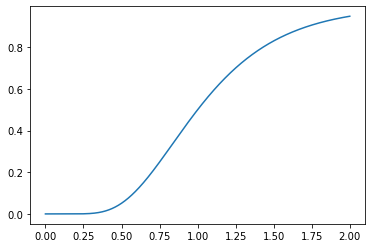

In [35]:
def N_cen(M):
    return 0.5*(1+scipy.special.erf(np.log(M)/0.6))

x = np.linspace(0,2,1000)
y = N_cen(x)

plt.plot(x,y)

The mean satellite number is defined by 
$<N_{sat}(M)> = <N_{cen}(M)> (\frac{M-M_0}{M_1})^{\alpha}$

which has a power-law shape. 

# Calculate Observed Halo Mass 

From Salcedo et al. 2020. 
The cluster-mass observable relation is a linear relation with a constant lognormal scatter:

$\ln M_{obs} = \ln M_c + \sigma_{\ln M_c} X $

The minimal mass for a halo to host a central is $\log M_{min} = \log M_{min,0} + Q_{env}(R_{\delta} - 0.5)$, in which $Q_{env}$ is the environmental dependence of galaxy occupation parameter. $R_\delta$ is the rank of halo environmental density measured with top-hat spheres of radius $8 h^{-1} \text{Mpc}$

# Halo occupation model

The occupation number of the halos is parametrized by 

$<N_{cen}(M)> = \frac{1}{2} [1+\text{erf} (\frac{\log M - \log M_{min}} {\sigma_{\log M}})] $

whose shape can be plotted as the following

# Calculate $\xi$

In [36]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
particle_rel_path = "abacus/particles_subsample.hdf5" 
galaxy_rel_path = "abacus/memHOD_11.2_12.4_0.65_1.0_0.2_0.0_0_z0p3.hdf5"
if shuffle == True:
    output_rel_path =  "data/shuffle_xi_output"
else:
    output_rel_path = "data/xi_output"
bin_rel_path = "bin_file.txt"

In [37]:
particle_path = os.path.join(project_path, particle_rel_path)
galaxy_path = os.path.join(project_path, galaxy_rel_path)
output_path = os.path.join(project_path,output_rel_path)
bin_path = os.path.join(project_path,bin_rel_path)

In [38]:
boxsize = 1100
rmin = 0.05
rmax = 125
nbins= 30
bins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)
binfile=bin_path
# mock_file1 = halo_path
mock_file2 = particle_path
output_file = output_path
siglnMc = 0.4
nc = 3.228E-6
Qsel = 0
nthreads = 4
zphot = False

In [39]:
print(bins)

[5.00000000e-02 6.48985018e-02 8.42363108e-02 1.09336207e-01
 1.41915121e-01 1.84201575e-01 2.39088125e-01 3.10329222e-01
 4.02798032e-01 5.22819776e-01 6.78604404e-01 8.80808183e-01
 1.14326263e+00 1.48392064e+00 1.92608452e+00 2.50000000e+00
 3.24492509e+00 4.21181554e+00 5.46681037e+00 7.09575606e+00
 9.21007875e+00 1.19544062e+01 1.55164611e+01 2.01399016e+01
 2.61409888e+01 3.39302202e+01 4.40404092e+01 5.71631315e+01
 7.41960319e+01 9.63042262e+01 1.25000000e+02]


In [40]:
import h5py as h5
import os.path
import numpy as np
import math
import Corrfunc

In [41]:
f = open(bin_path,"w")
for i in range(len(bins)-1):
    f.write("{:.2f} {:.2f}\n".format(bins[i],bins[i+1]))
f.close()

In [42]:
# f = h5.File(halo_path, 'r')
# print (type(f.keys()))
# print(type((f)))
# print(type(f['halos']))
# f.close()

In [43]:
import Corrfunc
from Corrfunc.theory.DD import DD

In [44]:
def calculateXi(bins,halo_df,mock_file2,nthreads,boxsize):

    dummy2 = h5.File(str(mock_file2), 'r')
    mock2 = dummy2['particles']
    
    N1 = len(halo_df)
    N2 = len(mock2)
    
    assert N1 != 0
    assert N2 != 0

    x1 = halo_df['pos_x'].to_numpy().astype(np.float32)
    y1 = halo_df['pos_y'].to_numpy().astype(np.float32)
    z1 = halo_df['pos_z'].to_numpy().astype(np.float32)
    
    x2 = mock2['x'].astype(np.float32)
    y2 = mock2['y'].astype(np.float32)
    z2 = mock2['z'].astype(np.float32)
    
        
    input_array = [x1,y1,z1,x2,y2,z2]
    for item in input_array:
        assert type(item) == np.ndarray

    
    results_DD = DD(0, 10, bins, X1=x1, Y1=y1, Z1=z1, X2=x2, Y2=y2, Z2=z2,verbose=True, periodic=True, isa="fastest", boxsize=1100)
    
    for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE

    print(N1, N2, boxsize)
    for i in range(0, len(results_DD)):
        RR = N1*N2*(4.0/3.0)*np.pi*(results_DD[i][1]**3.0 - results_DD[i][0]**3.0) / boxsize**3.0
        print("The value of RR is ", RR)
        results_DD[i][3] =  (results_DD[i][3]/RR - 1.0)
     
    # for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE
    return(results_DD)

In [45]:
halo_df_path=os.path.join(project_path,"data/lambda_spt_combined.pkl")
df = pd.read_pickle(halo_df_path)

In [46]:
projection_depth="30"

In [47]:
d30_mask= (~np.isnan(df[f"lambda_{projection_depth}"])) & (~np.isnan(df['pos_x']))

In [48]:
df_d30=df[d30_mask]

In [49]:
np.sum(df_d30["lambda_30"] >= 60 )

89

# Shuffle richness 

In [50]:
# 0.1 dex mass bins 
# 1 bin for 1E15 
# change richness bins

if shuffle == True:

    mass_all = df_d30['M500c']
    mass_all.describe()

    mass_all.hist(bins=20)
    plt.xscale('log')
    plt.yscale('log')

    start = np.log10(mass_all.min())
    end = 15
    step = 0.1
    top = np.log10(mass_all.max())
    num = round((end - start)/ step)
    print(start, end, step, top, num)

    mass_bins = np.append(np.linspace(start, end, num),top)
    print(mass_bins)

    df_d30.loc[:,'mass_bin'] = pd.cut(df_d30['M500c'],10**(mass_bins))

    mass_cats = df_d30['mass_bin'].unique()
    mass_cat = mass_cats[0]
    for mass_cat in mass_cats:
        mass_mask = df_d30['mass_bin'] == mass_cat
        preshuffled_lambda = df_d30[mass_mask]['lambda_30']
        shuffled_lambda = df_d30[mass_mask]['lambda_30'].sample(frac=1).to_numpy()
        df_d30.loc[mass_mask,'lambda_30'] = shuffled_lambda
        assert ~(preshuffled_lambda.equals(df_d30[mass_mask]['lambda_30']))

In [51]:
df_d30

,R_lambda_60,lambda_60,R_lambda_30_noperc,lambda_30_noperc,R_lambda_30,lambda_30,R_lambda_15,lambda_15,R_lambda_1,lambda_1,...,pos_y,pos_z,mean_ln_zeta,mean_ln_lambda,zeta,xi,xi_gt_45,xi_gt_5,zeta_gt_2,select
1,0.495934,3.0,0.525306,4.0,0.495934,3.0,0.495934,3.0,0.495934,3.0,...,414.536774,856.803711,-4.997203,None,0.006090,0.965050,0.0,0.0,0.0,0.0
3,0.525306,4.0,0.525306,4.0,0.525306,4.0,0.525306,4.0,0.525306,4.0,...,416.008942,856.025208,-6.653800,None,0.001281,2.686348,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.693145,16.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,412.486664,861.630676,-6.212496,None,0.002172,1.720677,0.0,0.0,0.0,0.0
14,0.717382,19.0,0.693145,16.0,0.693145,16.0,0.693145,16.0,0.717382,19.0,...,413.715729,857.441895,-4.987585,None,0.007464,2.734004,0.0,0.0,0.0,0.0
16,0.000000,0.0,0.674879,14.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,412.727478,860.821899,-6.441878,None,0.001600,0.552474,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552672,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,...,1021.007385,998.495972,-9.583038,None,0.000071,2.430621,0.0,0.0,0.0,0.0
9552978,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,...,844.980835,912.285828,-6.369392,None,0.001535,-0.080523,0.0,0.0,0.0,0.0
9553361,0.000000,0.0,0.495934,3.0,0.495934,3.0,0.495934,3.0,0.000000,0.0,...,938.113647,959.143311,-8.426752,None,0.000194,0.246841,0.0,0.0,0.0,0.0
9553832,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,0.457305,2.0,...,638.237488,852.464050,-7.152998,None,0.000656,2.276952,0.0,0.0,0.0,0.0


In [52]:
modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]

for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    print(lambda_lower, lambda_upper)
    df_richness_mask = (df_d30["lambda_30"] > lambda_lower) & (df_d30['lambda_30'] < lambda_upper)
    df_d30_richness_masked = df_d30[df_richness_mask]
    print(df_d30_richness_masked['lambda_30'].describe())
    
    for mode in modes:
        print(mode)
        if mode == "all":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked['zeta_gt_2']==1]
        elif mode == "SPT":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked["select"]==1]
        elif mode == "nonSPT":
            df_to_use = df_d30_richness_masked[df_d30_richness_masked["select"]==0]
        else: 
            raise

        xi = calculateXi(bins,df_to_use,galaxy_path,10,1100)
        
        print("---------------------------")
        print(xi[:][3])
        
        if shuffle == True:
            output_txt = f"data/shuffle_result_DD_{lambda_lower}_{mode}_d30.txt"
        else:
            output_txt = f"data/result_DD_{lambda_lower}_{mode}_d30.txt"

        outfile = open(os.path.join(project_path,output_txt), 'w')
        print(outfile)
        outfile.write("# rmin rmax xi\n")

        for bin in xi:
            outfile.write(str(bin[0])+" "+str(bin[1])+" "+str(bin[3])+"\n") 

        outfile.close()

20 30
count    19630.000000
mean        23.729598
std          2.377753
min         21.000000
25%         22.000000
50%         23.000000
75%         25.000000
max         29.000000
Name: lambda_30, dtype: float64
all


ND1 =          484 [xmin,ymin,zmin] = [3.573929,4.155802,1.014643], [xmax,ymax,zmax] = [1097.455078,1093.819824,1097.820557]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.836 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.862 secs


  0.050000   0.064899   0.000000         79   0.000000
  0.064899   0.084236   0.000000        137   0.000000
  0.084236   0.109336   0.000000        178   0.000000
  0.109336   0.141915   0.000000        345   0.000000
  0.141915   0.184202   0.000000        444   0.000000
  0.184202   0.239088   0.000000        604   0.000000
  0.239088   0.310329   0.000000        802   0.000000
  0.310329   0.402798   0.000000       1068   0.000000
  0.402798   0.522820   0.000000       1420   0.000000
  0.522820   0.678604   0.000000       1584   0.000000
  0.678604   0.880808   0.000000       1968   0.000000
  0.880808   1.143263   0.000000       2203   0.000000
  1.143263   1.483921   0.000000       2613   0.000000
  1.483921   1.926085   0.000000       4237   0.000000
  1.926085   2.500000   0.000000       5013   0.000000
  2.500000   3.244925   0.000000       5747   0.000000
  3.244925   4.211816   0.000000       8011   0.000000
  4.211816   5.466810   0.000000      13034   0.000000
  5.466810

ND1 =          162 [xmin,ymin,zmin] = [4.904932,4.155802,4.439480], [xmax,ymax,zmax] = [1097.455078,1090.665405,1097.820557]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.863 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.305 secs


  0.050000   0.064899   0.000000         26   0.000000
  0.064899   0.084236   0.000000         39   0.000000
  0.084236   0.109336   0.000000         64   0.000000
  0.109336   0.141915   0.000000        105   0.000000
  0.141915   0.184202   0.000000        188   0.000000
  0.184202   0.239088   0.000000        178   0.000000
  0.239088   0.310329   0.000000        232   0.000000
  0.310329   0.402798   0.000000        362   0.000000
  0.402798   0.522820   0.000000        431   0.000000
  0.522820   0.678604   0.000000        536   0.000000
  0.678604   0.880808   0.000000        669   0.000000
  0.880808   1.143263   0.000000        797   0.000000
  1.143263   1.483921   0.000000        939   0.000000
  1.483921   1.926085   0.000000       1335   0.000000
  1.926085   2.500000   0.000000       2122   0.000000
  2.500000   3.244925   0.000000       2227   0.000000
  3.244925   4.211816   0.000000       2883   0.000000
  4.211816   5.466810   0.000000       4906   0.000000
  5.466810

ND1 =        19468 [xmin,ymin,zmin] = [0.111286,0.040574,0.097670], [xmax,ymax,zmax] = [1099.927612,1099.921509,1099.841919]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.001 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.769 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 32.064 secs


  0.050000   0.064899   0.000000       4048   0.000000
  0.064899   0.084236   0.000000       5946   0.000000
  0.084236   0.109336   0.000000       7908   0.000000
  0.109336   0.141915   0.000000      11320   0.000000
  0.141915   0.184202   0.000000      14783   0.000000
  0.184202   0.239088   0.000000      19240   0.000000
  0.239088   0.310329   0.000000      23978   0.000000
  0.310329   0.402798   0.000000      28587   0.000000
  0.402798   0.522820   0.000000      34675   0.000000
  0.522820   0.678604   0.000000      40631   0.000000
  0.678604   0.880808   0.000000      49245   0.000000
  0.880808   1.143263   0.000000      52191   0.000000
  1.143263   1.483921   0.000000      61770   0.000000
  1.483921   1.926085   0.000000      80959   0.000000
  1.926085   2.500000   0.000000     102231   0.000000
  2.500000   3.244925   0.000000     148868   0.000000
  3.244925   4.211816   0.000000     230812   0.000000
  4.211816   5.466810   0.000000     368878   0.000000
  5.466810

ND1 =          297 [xmin,ymin,zmin] = [4.223823,5.310084,0.124862], [xmax,ymax,zmax] = [1091.829712,1099.614990,1099.538574]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.748 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.532 secs


  0.050000   0.064899   0.000000         58   0.000000
  0.064899   0.084236   0.000000         84   0.000000
  0.084236   0.109336   0.000000        155   0.000000
  0.109336   0.141915   0.000000        196   0.000000
  0.141915   0.184202   0.000000        298   0.000000
  0.184202   0.239088   0.000000        482   0.000000
  0.239088   0.310329   0.000000        603   0.000000
  0.310329   0.402798   0.000000        824   0.000000
  0.402798   0.522820   0.000000       1044   0.000000
  0.522820   0.678604   0.000000       1249   0.000000
  0.678604   0.880808   0.000000       1468   0.000000
  0.880808   1.143263   0.000000       1686   0.000000
  1.143263   1.483921   0.000000       2030   0.000000
  1.483921   1.926085   0.000000       2706   0.000000
  1.926085   2.500000   0.000000       3954   0.000000
  2.500000   3.244925   0.000000       4517   0.000000
  3.244925   4.211816   0.000000       5636   0.000000
  4.211816   5.466810   0.000000       8656   0.000000
  5.466810

ND1 =          115 [xmin,ymin,zmin] = [4.223823,30.964775,0.124862], [xmax,ymax,zmax] = [1091.829712,1099.614990,1099.538574]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.001 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.756 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.238 secs


  0.050000   0.064899   0.000000         21   0.000000
  0.064899   0.084236   0.000000         28   0.000000
  0.084236   0.109336   0.000000         47   0.000000
  0.109336   0.141915   0.000000         85   0.000000
  0.141915   0.184202   0.000000        108   0.000000
  0.184202   0.239088   0.000000        167   0.000000
  0.239088   0.310329   0.000000        248   0.000000
  0.310329   0.402798   0.000000        350   0.000000
  0.402798   0.522820   0.000000        425   0.000000
  0.522820   0.678604   0.000000        503   0.000000
  0.678604   0.880808   0.000000        594   0.000000
  0.880808   1.143263   0.000000        690   0.000000
  1.143263   1.483921   0.000000        858   0.000000
  1.483921   1.926085   0.000000       1034   0.000000
  1.926085   2.500000   0.000000       1774   0.000000
  2.500000   3.244925   0.000000       2206   0.000000
  3.244925   4.211816   0.000000       2411   0.000000
  4.211816   5.466810   0.000000       3807   0.000000
  5.466810

ND1 =         3490 [xmin,ymin,zmin] = [0.598797,0.090084,0.056943], [xmax,ymax,zmax] = [1099.474609,1099.907837,1099.840454]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.750 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  5.685 secs


  0.050000   0.064899   0.000000        716   0.000000
  0.064899   0.084236   0.000000       1136   0.000000
  0.084236   0.109336   0.000000       1736   0.000000
  0.109336   0.141915   0.000000       2302   0.000000
  0.141915   0.184202   0.000000       3002   0.000000
  0.184202   0.239088   0.000000       4296   0.000000
  0.239088   0.310329   0.000000       5254   0.000000
  0.310329   0.402798   0.000000       6709   0.000000
  0.402798   0.522820   0.000000       7893   0.000000
  0.522820   0.678604   0.000000       9662   0.000000
  0.678604   0.880808   0.000000      11555   0.000000
  0.880808   1.143263   0.000000      12775   0.000000
  1.143263   1.483921   0.000000      15488   0.000000
  1.483921   1.926085   0.000000      21130   0.000000
  1.926085   2.500000   0.000000      24759   0.000000
  2.500000   3.244925   0.000000      33365   0.000000
  3.244925   4.211816   0.000000      50936   0.000000
  4.211816   5.466810   0.000000      77967   0.000000
  5.466810

ND1 =           60 [xmin,ymin,zmin] = [44.843597,53.423672,13.212649], [xmax,ymax,zmax] = [1071.183228,1072.442139,1072.848755]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.749 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.154 secs


  0.050000   0.064899   0.000000         15   0.000000
  0.064899   0.084236   0.000000         25   0.000000
  0.084236   0.109336   0.000000         35   0.000000
  0.109336   0.141915   0.000000         49   0.000000
  0.141915   0.184202   0.000000         61   0.000000
  0.184202   0.239088   0.000000         93   0.000000
  0.239088   0.310329   0.000000        153   0.000000
  0.310329   0.402798   0.000000        194   0.000000
  0.402798   0.522820   0.000000        225   0.000000
  0.522820   0.678604   0.000000        298   0.000000
  0.678604   0.880808   0.000000        357   0.000000
  0.880808   1.143263   0.000000        412   0.000000
  1.143263   1.483921   0.000000        465   0.000000
  1.483921   1.926085   0.000000        562   0.000000
  1.926085   2.500000   0.000000        896   0.000000
  2.500000   3.244925   0.000000       1081   0.000000
  3.244925   4.211816   0.000000       1353   0.000000
  4.211816   5.466810   0.000000       1782   0.000000
  5.466810

ND1 =           33 [xmin,ymin,zmin] = [87.459854,53.423672,13.212649], [xmax,ymax,zmax] = [1071.183228,1072.442139,1015.957886]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.799 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.079 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000         13   0.000000
  0.084236   0.109336   0.000000         26   0.000000
  0.109336   0.141915   0.000000         22   0.000000
  0.141915   0.184202   0.000000         23   0.000000
  0.184202   0.239088   0.000000         55   0.000000
  0.239088   0.310329   0.000000         79   0.000000
  0.310329   0.402798   0.000000        117   0.000000
  0.402798   0.522820   0.000000        135   0.000000
  0.522820   0.678604   0.000000        193   0.000000
  0.678604   0.880808   0.000000        217   0.000000
  0.880808   1.143263   0.000000        273   0.000000
  1.143263   1.483921   0.000000        309   0.000000
  1.483921   1.926085   0.000000        336   0.000000
  1.926085   2.500000   0.000000        567   0.000000
  2.500000   3.244925   0.000000        673   0.000000
  3.244925   4.211816   0.000000        861   0.000000
  4.211816   5.466810   0.000000       1091   0.000000
  5.466810

ND1 =          375 [xmin,ymin,zmin] = [13.890323,3.963098,4.092882], [xmax,ymax,zmax] = [1095.980835,1094.688477,1096.161743]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.750 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.664 secs


  0.050000   0.064899   0.000000         95   0.000000
  0.064899   0.084236   0.000000        132   0.000000
  0.084236   0.109336   0.000000        163   0.000000
  0.109336   0.141915   0.000000        238   0.000000
  0.141915   0.184202   0.000000        408   0.000000
  0.184202   0.239088   0.000000        417   0.000000
  0.239088   0.310329   0.000000        538   0.000000
  0.310329   0.402798   0.000000        758   0.000000
  0.402798   0.522820   0.000000        963   0.000000
  0.522820   0.678604   0.000000       1112   0.000000
  0.678604   0.880808   0.000000       1450   0.000000
  0.880808   1.143263   0.000000       1574   0.000000
  1.143263   1.483921   0.000000       2016   0.000000
  1.483921   1.926085   0.000000       2904   0.000000
  1.926085   2.500000   0.000000       3492   0.000000
  2.500000   3.244925   0.000000       4087   0.000000
  3.244925   4.211816   0.000000       5637   0.000000
  4.211816   5.466810   0.000000       8753   0.000000
  5.466810

ND1 =           20 [xmin,ymin,zmin] = [39.042103,47.143677,2.513159], [xmax,ymax,zmax] = [1017.470947,953.315002,1096.332275]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.775 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.053 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000          6   0.000000
  0.084236   0.109336   0.000000          7   0.000000
  0.109336   0.141915   0.000000         17   0.000000
  0.141915   0.184202   0.000000         28   0.000000
  0.184202   0.239088   0.000000         34   0.000000
  0.239088   0.310329   0.000000         41   0.000000
  0.310329   0.402798   0.000000         54   0.000000
  0.402798   0.522820   0.000000         78   0.000000
  0.522820   0.678604   0.000000         85   0.000000
  0.678604   0.880808   0.000000        151   0.000000
  0.880808   1.143263   0.000000        157   0.000000
  1.143263   1.483921   0.000000        129   0.000000
  1.483921   1.926085   0.000000        198   0.000000
  1.926085   2.500000   0.000000        307   0.000000
  2.500000   3.244925   0.000000        317   0.000000
  3.244925   4.211816   0.000000        366   0.000000
  4.211816   5.466810   0.000000        651   0.000000
  5.466810

ND1 =            6 [xmin,ymin,zmin] = [39.042103,227.412338,2.513159], [xmax,ymax,zmax] = [1017.470947,576.711792,754.795654]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.750 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.026 secs


  0.050000   0.064899   0.000000          4   0.000000
  0.064899   0.084236   0.000000          2   0.000000
  0.084236   0.109336   0.000000          3   0.000000
  0.109336   0.141915   0.000000          6   0.000000
  0.141915   0.184202   0.000000          6   0.000000
  0.184202   0.239088   0.000000          9   0.000000
  0.239088   0.310329   0.000000         12   0.000000
  0.310329   0.402798   0.000000         25   0.000000
  0.402798   0.522820   0.000000         31   0.000000
  0.522820   0.678604   0.000000         27   0.000000
  0.678604   0.880808   0.000000         54   0.000000
  0.880808   1.143263   0.000000         53   0.000000
  1.143263   1.483921   0.000000         39   0.000000
  1.483921   1.926085   0.000000         71   0.000000
  1.926085   2.500000   0.000000        122   0.000000
  2.500000   3.244925   0.000000        122   0.000000
  3.244925   4.211816   0.000000        111   0.000000
  4.211816   5.466810   0.000000        199   0.000000
  5.466810

ND1 =           77 [xmin,ymin,zmin] = [15.081444,47.143677,4.043571], [xmax,ymax,zmax] = [1099.429443,1098.228760,1096.332275]
ND2 =     18284673 [xmin,ymin,zmin] = [0.000000,0.000068,0.000004], [xmax,ymax,zmax] = [1100.000000,1100.000000,1099.999756]
Running with points in [xmin,xmax] = 0.000000,1100.000000 with periodic wrapping = 1100.000000
Running with points in [ymin,ymax] = 0.000068,1100.000000 with periodic wrapping = 1100.000000
Running with points in [zmin,zmax] = 0.000004,1099.999756 with periodic wrapping = 1100.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   1.769 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.157 secs


  0.050000   0.064899   0.000000         14   0.000000
  0.064899   0.084236   0.000000         37   0.000000
  0.084236   0.109336   0.000000         25   0.000000
  0.109336   0.141915   0.000000         52   0.000000
  0.141915   0.184202   0.000000         70   0.000000
  0.184202   0.239088   0.000000        116   0.000000
  0.239088   0.310329   0.000000        111   0.000000
  0.310329   0.402798   0.000000        173   0.000000
  0.402798   0.522820   0.000000        251   0.000000
  0.522820   0.678604   0.000000        255   0.000000
  0.678604   0.880808   0.000000        354   0.000000
  0.880808   1.143263   0.000000        376   0.000000
  1.143263   1.483921   0.000000        541   0.000000
  1.483921   1.926085   0.000000        799   0.000000
  1.926085   2.500000   0.000000        970   0.000000
  2.500000   3.244925   0.000000        916   0.000000
  3.244925   4.211816   0.000000       1309   0.000000
  4.211816   5.466810   0.000000       2091   0.000000
  5.466810

In [53]:
# if shuffle == True:
#     result_rel_path = "data/shuffle_results.npz"
# else:
#     result_rel_path = "data/results.npz"

# results_path = os.path.join(project_path,"data/shuffle_results.npz")
# np.savez(results_path,results_DD)

# print(results_path)

In [54]:
# test function
from __future__ import print_function
import numpy as np
from os.path import dirname, abspath, join as pjoin
import Corrfunc
from Corrfunc.theory.DD import DD
binfile = pjoin(dirname(abspath(Corrfunc.__file__)),"../theory/tests/", "bins")
N = 10000
boxsize = 420.0
nthreads = 4
autocorr = 1
seed = 42
np.random.seed(seed)
X = np.random.uniform(0, boxsize, N)
Y = np.random.uniform(0, boxsize, N)
Z = np.random.uniform(0, boxsize, N)
weights = np.ones_like(X)
results = DD(autocorr, nthreads, binfile, X, Y, Z, weights1=weights,
             weight_type='pair_product', output_ravg=True,
             boxsize=boxsize, periodic=True,verbose=True)
for r in results: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".
                        format(r['rmin'], r['rmax'], r['ravg'],
                               r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE

Running with points in [xmin,xmax] = 0.004887,419.881423 with periodic wrapping = 420.000000
Running with points in [ymin,ymax] = 0.066253,419.968427 with periodic wrapping = 420.000000
Running with points in [zmin,zmax] = 0.020212,419.958410 with periodic wrapping = 420.000000
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 35,35,17.  Time taken =   0.003 sec
Using fallback kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.011 secs


  0.167536   0.238755   0.000000          0   0.000000
  0.238755   0.340251   0.000000          0   0.000000
  0.340251   0.484892   0.000000          0   0.000000
  0.484892   0.691021   0.000000          0   0.000000
  0.691021   0.984777   0.945372          2   1.000000
  0.984777   1.403410   1.340525         10   1.000000
  1.403410   2.000000   1.732968         36   1.000000
  2.000000   2.850200   2.549059         52   1.000000
  2.850200   4.061840   3.559061        210   1.000000
  4.061840   5.788530   4.996275        670   1.000000
  5.788530   8.249250   7.124926       2156   1.000000
  8.249250  11.756000  10.201393       5990   1.000000
 11.756000  16.753600  14.517498      17736   1.000000
 16.753600  23.875500  20.716714      50230   1.000000


In [ ]:
help(DD)